# Business Intelligence 2 Project - GPS Data - Model Building

**Authors:** Brandl Moritz & Miklautz Lukas

Feel free to checkout our project on [github](https://github.com/MoBran/bi2_project)


**Short Summary:**

In this notebook, we perform a prediction of wether a traffic jam on a specific route is likely or not in the city of Aracaju in Brazil. The data consists of GPS tracking data gathered in the city Aracaju in Brazil. The data set includes two tables. The **go_track_tracks.csv** and the **go_track_trackspoints.csv**. The first one, from here on referred to as tracks data set, contains general information about each recorded trip, like average speed, distance, traffic rating, rating of bus etc. The second table, called trackspoints, contains the GPS data for each trip and the time intervals. 

**Findings:**

We found during data exploration that there are several problems in regard of data quality:
- 17 % of the data are either 0 or duplicate values.
- Time lags in the recorded data between 5 and 20 minutes
- Inconsistent records e.g. some users went by car and submitted a bus rating
- Large discrepancy between travel time per track_id stated in the tracks data table and the one calculated from the trackspoints data table up to 25 minutes. 
- More than 80 % of the data was generated by 8 users out of 28

During the feature engineering process we used the data from tracks table ended up using the following features:
- distance: standardized distance of the track 
- car_or_bus:  Binary variable indicating whether the car == 1 was used or the bus == 0
- month_sinus: Month 0-11 transformed to fit on the unit circle
- month_cosinus: Month 0-11 transformed to fit on the unit circle
- weekday_sinus: Weekday 0-6 transformed to fit on the unit circle
- weekday_cosinus: Weekday 0-6 transformed to fit on the unit circle
- daytime_start_sinus: Hour of the day when the trip started 0-23 transformed to fit on the unit circle
- daytime_start_cosinus: Hour of the day when the trip started 0-23 transformed to fit on the unit circle


For the trackspoints data table we identified the following features:
- quantiles per latitude and longitude
- latitude and longitude per time interval

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import validation_curve
from sklearn.utils import resample
from sklearn.svm import SVC
import datetime as dt
#Visualisation Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import seaborn as sns


# Self written packages
from data.make_data import DataSet
from utils.general_utils import rescale_gps_data


In [2]:
parentdir = os.path.dirname(os.getcwd())
datadir = os.path.join(parentdir, "data", "preprocessed_and_feature_engineered")
dataset = DataSet(datadir,file_ending=".csv")
feature_engineered_tracks, trackspoints = dataset.get_data()
trackspoints = dataset._preprocess_trackspoint_data(trackspoints)

----
## Features from Track Data Table


In [3]:
feature_engineered_tracks.head(10)


,speed,time,distance,rating,car_or_bus,month_sinus,month_cosinus,weekday_sinus,weekday_cosinus,daytime_start_sinus,daytime_start_cosinus,daytime_end_sinus,daytime_end_cosinus
0,0.246971,-0.475080,-0.385348,3,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,0.933580,-0.358368,0.920508,-0.390723
1,1.067705,-0.309716,0.126611,3,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,-0.410727,-0.911758,-0.453990,-0.891007
2,-0.151523,-0.845665,-0.721867,3,0,-0.866025,-5.000000e-01,0.974928,-0.222521,0.975342,0.220697,0.979047,0.203633
3,0.286189,1.128527,0.594322,3,0,-0.866025,-5.000000e-01,0.974928,-0.222521,0.975342,0.220697,0.994522,0.104528
4,0.712205,-1.029686,-0.124711,2,1,-0.866025,-5.000000e-01,-0.433884,-0.900969,-0.782603,-0.622521,-0.788016,-0.615655
5,-1.012846,-1.161977,-0.898277,2,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,0.713244,-0.700915,0.713244,-0.700915
6,1.491029,-0.034109,0.730560,3,1,-0.866025,-5.000000e-01,-0.781831,0.623490,-0.984042,-0.177935,-0.992545,-0.121878
7,0.119644,-0.981349,-0.769026,3,0,-0.866025,-5.000000e-01,0.781831,0.623490,0.473312,-0.880895,0.465615,-0.884988
8,-0.022088,1.496569,0.674085,3,0,-0.866025,-5.000000e-01,0.781831,0.623490,0.438363,-0.898798,0.313172,-0.949696
9,-0.047060,-0.069726,-0.264054,3,1,-1.000000,-1.836970e-16,0.974928,-0.222521,-0.422626,-0.906304,-0.473312,-0.880895


In [4]:
# Delete id and id_android features
if "id" in feature_engineered_tracks.columns:
    feature_engineered_tracks = feature_engineered_tracks.drop(["id","id_android"],axis=1)

----
## Features from Trackspoints Data Table


We can see that after the preprocessing and feature engineering only the records inside the city are left.


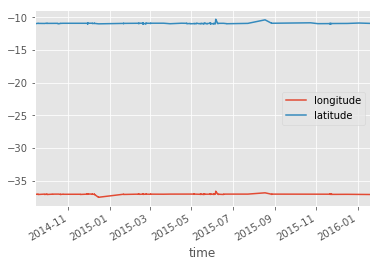

In [5]:
trackspoints[["longitude","latitude","time"]].set_index("time").plot(legend=True);


As we can see there is now only a little bit of variation in the data, thats why we only look at the decimal points. The variation can be seen in the next plot.

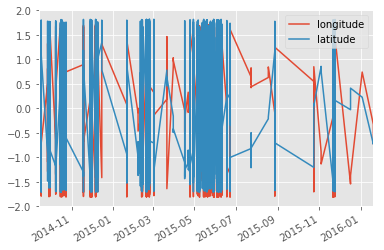

In [6]:
trackspoints_scaled = rescale_gps_data(trackspoints.set_index("time"), scale_by=1000,
                                       standardize=True)
trackspoints_scaled[["longitude","latitude"]].plot(legend=True);


** Trackspoints per quantile **

In [7]:
datadir_trackspoints = os.path.join(datadir,"trackspoints")
trackspoints_per_quantile = pd.read_csv(os.path.join(datadir_trackspoints,"trackspoints_per_quantile_5.csv"),
                                        index_col = "track_id")

trackspoints_per_quantile = rescale_gps_data(trackspoints_per_quantile,
                                             scale_by=1000, standardize=True)



trackspoints_per_quantile.head(10)

,latitude_quantile_0,longitude_quantile_0,latitude_quantile_1,longitude_quantile_1,latitude_quantile_2,longitude_quantile_2,latitude_quantile_3,longitude_quantile_3,latitude_quantile_4,longitude_quantile_4,latitude_quantile_5,longitude_quantile_5,rating
1,1.257946,-1.089787,0.448086,0.606415,0.441108,-1.936055,-0.506359,-0.841033,-0.254235,0.334737,1.971421,-1.301733,3
2,0.860453,0.207891,0.935568,-0.843804,-1.279776,0.344824,-0.313834,0.795736,-1.079719,-1.863668,-1.254503,-1.726949,3
3,1.985415,0.765139,-0.191394,1.245922,-0.534168,1.341316,-1.161847,-0.322947,-1.180345,-0.835673,-0.935831,-0.181801,3
4,-0.978493,0.443003,0.342969,0.310641,-0.003323,-1.915751,1.019730,-0.638706,1.838258,-0.049654,1.514637,-0.913366,3
8,-0.509090,0.556065,-0.729399,0.420410,-1.142384,-1.117651,-1.161965,-0.916313,1.413703,-1.336191,0.820165,1.375701,2
10,-0.812293,0.425962,-0.915742,0.670638,-0.921706,0.399058,-1.279447,0.510973,-1.264041,0.431699,-1.048782,0.385066,2
11,0.550758,-1.198118,0.822055,-1.048062,1.384669,1.596218,-1.085496,1.655962,-0.458945,1.151170,-0.353072,0.975473,3
12,0.937896,1.175337,-0.823957,1.803266,1.953983,1.436738,1.184203,1.511686,-0.846387,-1.835961,-0.846957,0.999013,3
13,-0.840635,0.989823,-1.285669,0.685105,0.665091,0.744749,-0.294765,-0.328576,0.832759,1.040568,-0.516682,1.560454,3
16,-0.791371,-0.775470,-0.386108,-0.850470,1.037044,0.736585,-1.043415,0.864649,-0.379944,-1.119314,-0.912416,0.327733,3


**Trackspoints per time interval**

In [8]:
from sklearn.preprocessing import scale

trackspoints_per_timeinterval = pd.read_csv(os.path.join(datadir_trackspoints,"trackspoints_per_time_interval_10_and_max_time_40.csv"),
                                        index_col = "track_id")


trackspoints_per_timeinterval = rescale_gps_data(trackspoints_per_timeinterval,
                                                 scale_by=1000, standardize=True)
ratings = trackspoints_per_timeinterval["rating"]
colnames = list(trackspoints_per_timeinterval.drop("rating",axis=1).columns.values)
trackspoints_per_timeinterval = pd.DataFrame(scale(trackspoints_per_timeinterval.drop("rating",axis=1)),
                                         columns=colnames, 
                                         index=list(trackspoints_per_timeinterval.index))

trackspoints_per_timeinterval["rating"] = ratings

trackspoints_per_timeinterval.head(10)

,latitude_time_0,longitude_time_0,latitude_time_10,longitude_time_10,latitude_time_20,longitude_time_20,latitude_time_30,longitude_time_30,latitude_time_40,longitude_time_40,rating
1,1.257946,-1.089787,1.688611,-1.255292,-0.911441,-1.070036,-0.655689,-0.663477,-0.436967,-0.444125,3
2,0.860453,0.207891,-0.220482,0.711876,-0.779568,-0.728162,-0.655689,-0.663477,-0.436967,-0.444125,3
3,1.985415,0.765139,-1.019587,-0.147844,-0.911441,-1.070036,-0.655689,-0.663477,-0.436967,-0.444125,3
4,-0.978493,0.443003,0.483195,1.311600,0.650278,0.925865,1.011285,-0.416421,3.054483,0.862036,3
8,-0.509090,0.556065,0.616179,1.392294,-0.911441,-1.070036,-0.655689,-0.663477,-0.436967,-0.444125,2
10,-0.812293,0.425962,-1.124805,0.412703,-0.911441,-1.070036,-0.655689,-0.663477,-0.436967,-0.444125,2
11,0.550758,-1.198118,0.829713,-2.099543,0.060154,1.366245,-0.655689,-0.663477,-0.436967,-0.444125,3
12,0.937896,1.175337,-0.936799,1.019806,-0.911441,-1.070036,-0.655689,-0.663477,-0.436967,-0.444125,3
13,-0.840635,0.989823,0.852554,-1.714995,0.523968,1.583373,2.330248,1.490735,0.617873,3.437310,3
16,-0.791371,-0.775470,1.869132,-0.500751,-0.460900,0.864239,-0.655689,-0.663477,-0.436967,-0.444125,3


----
## Model Building

In this section we will see how different models will be fitted and then tested against an hold out validation set

**Challenges**
- Large Feature Space and low number of observations
- Unbalanced Data Set: There are far more ratings with 2 or 3 than with 1
- Data quality is quite poor

**Approaches**
- Downsampling of majority labels
- Binarization of the target value 
- Majority Vote Classifier

In the following we are using a setup with 70% training data, 20% test data and a 10% validation set.

In [9]:
from model.train_model import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
random_state = 1
drop_columns = ["time","speed","daytime_end_sinus",
                "daytime_end_cosinus", "rating"]
test_size = 0.20
validation_size = 0.10
nr_of_validation_samples = round(len(feature_engineered_tracks)*validation_size)
validation_set = resample(feature_engineered_tracks, replace=False,
                          n_samples=nr_of_validation_samples,
                          random_state=random_state)
feature_engineered_tracks = feature_engineered_tracks.drop(validation_set.index)

---
### Multiclass Prediction of Rating 1,2,3
### **Down-sample Majority Class**

idea from [here](https://elitedatascience.com/imbalanced-classes)

Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm.

We know that we have: 

In [10]:
nr_of_observations = 0
for rating in range(1,4):
    nr_of_rated_tracks = len(feature_engineered_tracks[feature_engineered_tracks["rating"]==rating])
    nr_of_observations += nr_of_rated_tracks
    percentage = round(nr_of_rated_tracks/len(feature_engineered_tracks) * 100)
    print("Number tracks with rating {}: {} thats {}% of observations".format(rating, nr_of_rated_tracks,
                                                                              percentage))
print("The total number of observations is", str(nr_of_observations))

Number tracks with rating 1: 13 thats 12% of observations
Number tracks with rating 2: 35 thats 31% of observations
Number tracks with rating 3: 65 thats 58% of observations
The total number of observations is 113


In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from visualization.visualize import plot_multiclass_ROC_curve
random_state = 1
tracks = feature_engineered_tracks
df_majority = tracks[tracks["rating"]==3]
df_median = tracks[tracks["rating"]==2]
df_minority = tracks[tracks["rating"]==1]

downsampling_size = nr_of_rated_tracks = len(tracks[tracks["rating"]==1])
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=downsampling_size,    # to match minortiy class
                                 random_state=random_state) # reproducible results


df_median_downsampled = resample(df_median, 
                                 replace=False,     # sample without replacement
                                 n_samples=downsampling_size,    # to match minortiy class
                                 random_state=random_state) # reproducible results


df_downsampled = pd.concat([df_majority_downsampled,df_median_downsampled, df_minority])

y = label_binarize(df_downsampled["rating"], classes=[1, 2, 3])
y = pd.DataFrame(y, columns=[1,2,3])


X_train, X_test, y_train, y_test = train_test_split(df_downsampled.drop(drop_columns,axis=1),
                                                    y,
                                                    test_size=test_size, 
                                                    random_state=random_state)


remaining_majority = df_majority.drop(list(df_majority_downsampled.index))
remaining_median = df_median.drop(list(df_median_downsampled.index))


y_remaining_majority = label_binarize(remaining_majority["rating"], classes=[1, 2, 3])
y_remaining_majority = pd.DataFrame(y_remaining_majority, columns=[1,2,3])
y_remaining_median = label_binarize(remaining_median["rating"], classes=[1, 2, 3])
y_remaining_median = pd.DataFrame(y_remaining_median, columns=[1,2,3])
y_test_concatenated = pd.concat([y_remaining_majority,
                                 y_remaining_median,
                                 y_test])

X_remaining_majority = remaining_majority.drop(drop_columns,axis=1)
X_remaining_median = remaining_median.drop(drop_columns,axis=1)

X_test_concatenated = pd.concat([X_remaining_majority,
                                 X_remaining_median,
                                 X_test])


**The downsampled data set has now equal values for each rating label**

In [12]:
print(repr(df_downsampled.rating.value_counts()))

3    13
2    13
1    13
Name: rating, dtype: int64


**For testing of the Random Forest we include the dropped values into the test set**

In [13]:
print("Test Set Size with Discarded Observations: ", len(y_test_concatenated))
print("Test Set Size original: ", len(y_test))

Test Set Size with Discarded Observations:  82
Test Set Size original:  8


ROC-Macro Score:  0.60857


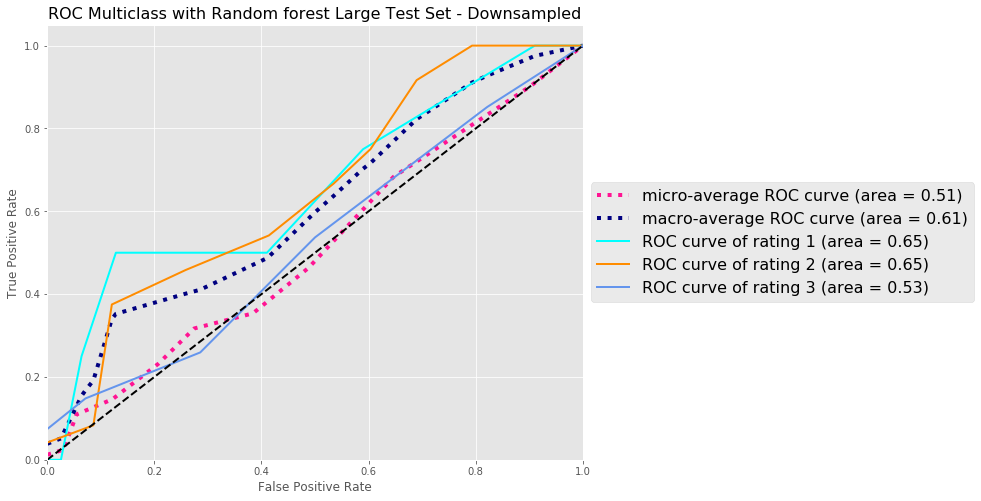

In [14]:
downsampled_rf_classifier = OneVsRestClassifier(RandomForestClassifier(random_state=random_state,
                                                        n_estimators = 10))
y_score = downsampled_rf_classifier.fit(X_train, y_train).predict_proba(X_test_concatenated)
print("ROC-Macro Score: ",round(roc_auc_score(y_test_concatenated, 
                                        y_score,
                                        average="macro"),5) )

plot_title = "ROC Multiclass with Random forest Large Test Set - Downsampled"
plot_multiclass_ROC_curve(y_test_concatenated, y_score, title = plot_title)

**Confusion Matrix**

In [15]:
from model.train_model import binary_to_multi
prediction = binary_to_multi(y_score)
confusion_matrix(binary_to_multi(np.array(y_test_concatenated)),prediction)

Predicted label,1,2,3
True label,,,
1,2,1,1
2,4,19,1
3,16,31,7


---
### **Use Binary Predictor**
- 1 == Traffic Jam
- 0 == No Traffic Jam

In order to make the problem a bit simpler and also avoid the challenges of imbalanced data sets we assigned to **1-Traffic Jam** all ratings with 1 or 2 and ratings with 3 to **0-No Traffic Jam**. With this new "more" balanced predictor we tried to improve our prediction accuracy and auc value. The new label distribution is:

In [16]:
# Train Test Split
from utils.general_utils import get_binary_labels
y = list(feature_engineered_tracks["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1's: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0's: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(drop_columns,axis=1),
                                                    y, test_size=test_size, random_state=random_state)

Number of 1's:  48
Number of 0's:  65


----
### Start with trackspoints data
#### Predict rating from trackspoints with binary label and Logistic Regression


Number of 1:  51
Number of 0:  75
Mean Training Accuracy:	  0.67
Mean Test Accuracy:	  0.577


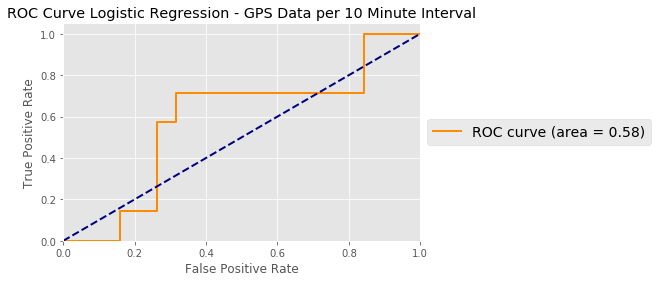

In [17]:
from model.train_model import report_model_performance
from visualization.visualize import plot_ROC_curve
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

features_to_use = trackspoints_per_timeinterval
# Train Test Split
y = list(features_to_use["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(features_to_use.drop("rating",axis=1),
                                                    y, test_size=test_size, random_state=random_state)



# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    class_weight="balanced"))

y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print("Mean Training Accuracy:\t ", round(classifier.score(X_train,y_train),3))
print("Mean Test Accuracy:\t ", round(classifier.score(X_test,y_test),3))

plot_ROC_curve(y_test, y_score, title="ROC Curve Logistic Regression - GPS Data per 10 Minute Interval")

**Confusion Matrix**

We see that it's only predicting 1

In [18]:
from model.train_model import binary_to_multi
prediction = binary_to_multi(y_score)
confusion_matrix(y_test,prediction)

Predicted label,0,1
True label,,
0,0,19
1,0,7


Regularization parameter C does not really influence the validation accuracy.

In [19]:
pipe_lr = Pipeline([('clf', LogisticRegression(random_state=random_state))])

param_range = [i*0.01 for i in range(1,25,1)]
train_scores, test_scores = \
        validation_curve(estimator=pipe_lr, 
                         X=X_train, 
                         y=y_train, 
                         param_name='clf__C', 
                         param_range=param_range,
                         cv=5)



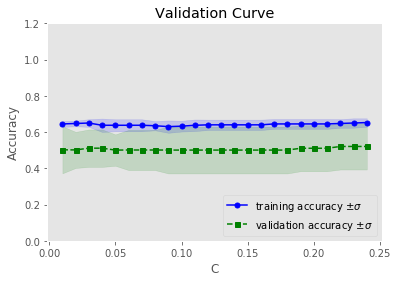

In [20]:
from visualization.visualize import plot_validation_curves
plot_validation_curves(train_scores, test_scores, 
                       param_range, xlabel="C")

----
#### Predict rating from trackspoints with binary label by a Random Forest including Grid Search for Hyperparameter Tuning

Additionaly the threshold of the prediction probabilities is adjusted to be more sensitive

Best Score:  0.619692460317
Best Parameters: 
 {'clf__class_weight': 'balanced', 'clf__max_features': 'auto', 'clf__n_estimators': 10, 'clf__criterion': 'gini', 'clf__random_state': 4}
Mean Accuracy no Threshold:	  0.619
Mean Accuracy with Threshold:	  0.548
prediction probabilities:
      0    1
0  1.0  0.0
1  0.3  0.7
2  0.5  0.5
3  0.5  0.5
4  0.6  0.4
Apply probability threshold at:  0.49
Prediction:
 [0, 1, 1, 1, 0, 1, 0, 0, 0, 1]
True Label:
 [0, 0, 1, 1, 0, 0, 1, 0, 0, 0]

Confusion Matrix: 
 Predicted label   0   1
True label             
0                15  12
1                 7   8


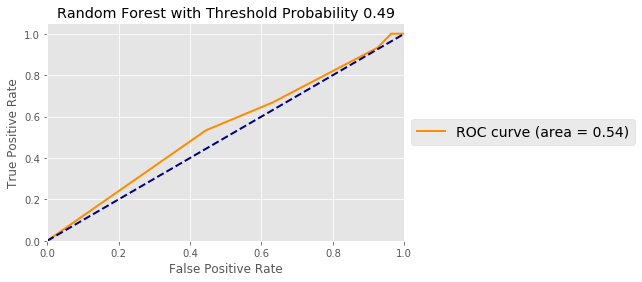

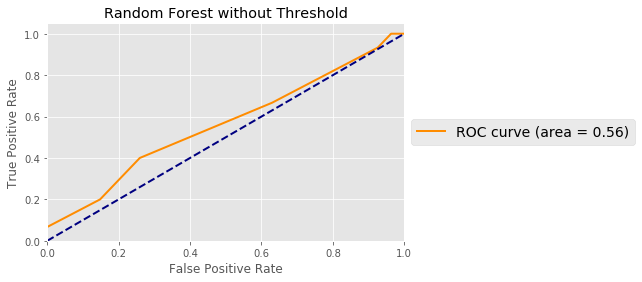

In [21]:
from sklearn.ensemble import RandomForestClassifier 
from model.train_model import report_model_performance
from visualization.visualize import plot_ROC_curve
from sklearn.metrics import accuracy_score

features_to_use = trackspoints_per_timeinterval

# Train Test Split
y = list(features_to_use["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(features_to_use.drop("rating",axis=1),
                                                    y, test_size=0.33, random_state=random_state)


pipe_rf = Pipeline([('clf', RandomForestClassifier())])
param_grid = [{'clf__n_estimators': [5,10,15,20], 
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced"]}
             ]
gs = GridSearchCV(estimator=pipe_rf, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   #refit="roc_auc",
                   cv=5)
gs = gs.fit(X_train, y_train)
print("Best Score: ",gs.best_score_) 
print("Best Parameters: \n", gs.best_params_)


classifier = gs.best_estimator_

classifier = classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

probability_threshold = 0.49
traffic_jam_prediction = [1 if prob[1] >= probability_threshold else 0 \
                          for prob in y_score]
traffic_jam_probabilities = [0.99 if prob[1] >= probability_threshold else prob[1] \
                          for prob in y_score]

print("Mean Accuracy no Threshold:\t ", round(classifier.score(X_test,y_test),3))
print("Mean Accuracy with Threshold:\t ", round(accuracy_score(traffic_jam_prediction,y_test),3))
print("prediction probabilities:\n",pd.DataFrame(y_score[0:5],columns=[0,1]))
print("Apply probability threshold at: ", probability_threshold)
print("Prediction:\n", traffic_jam_prediction[0:10])
print("True Label:\n", [i for i in y_test[0:10]])
print("\nConfusion Matrix: \n",confusion_matrix(y_test,traffic_jam_prediction))

prediction_probabilities_class_1 = y_score[:,1]
plot_ROC_curve(y_test, traffic_jam_probabilities, title="Random Forest with Threshold Probability " + str(probability_threshold) )
plot_ROC_curve(y_test, prediction_probabilities_class_1, title="Random Forest without Threshold")




**Validation Curves - To visualize problem of overfitting with Random Forest**

We can see that the random forest model is very prone to overfitting in regard to its number of estimators in the ensemble. This could be due to the small amount of data.

In [22]:
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=random_state))])

param_grid = [{'clf__n_estimators': [i for i in range(1,31,1)],#[5,10,15,20,25,30,35, 40,45,50], 
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced","balanced_subsample"]}
             ]
param_range = param_grid[0]["clf__n_estimators"]
train_scores, test_scores = \
        validation_curve(estimator=pipe_rf, 
                         X=X_train, 
                         y=y_train, 
                         param_name='clf__n_estimators', 
                         param_range=param_range,
                         cv=5)

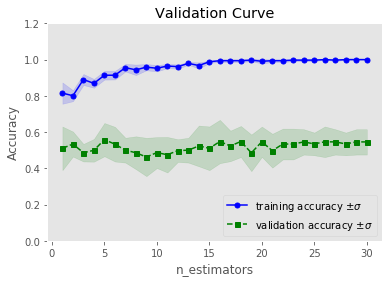

In [23]:
from visualization.visualize import plot_validation_curves
plot_validation_curves(train_scores, test_scores, 
                       param_range, xlabel="n_estimators")

----
### Start with tracks data
**Binary Class Prediction with Random Forest and 5 fold Cross Validation + Hyperparameter Tuning**

In [24]:
# Train Test Split
from utils.general_utils import get_binary_labels
y = list(feature_engineered_tracks["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1's: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0's: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(drop_columns,axis=1),
                                                    y, test_size=test_size, random_state=random_state)
pipe_rf = Pipeline([('clf', RandomForestClassifier())])
param_grid = [{'clf__n_estimators': [1,2,3,4,5,10,15,20], 
                'clf__criterion': ["gini","entropy"],
                'clf__max_features': ['auto','sqrt','log2'],
                'clf__random_state': [random_state,123,4,5],
                'clf__class_weight': ["balanced","balanced_subsample"]}
             ]
gs = GridSearchCV(estimator=pipe_rf, 
                   param_grid=param_grid, 
                   scoring='roc_auc', 
                   cv=10,
                   n_jobs=-1)

gs = gs.fit(X_train, y_train)
print("Best Score: ",gs.best_score_) 
print("Best Parameters: \n", gs.best_params_)

Number of 1's:  48
Number of 0's:  65
Best Score:  0.831944444444
Best Parameters: 
 {'clf__class_weight': 'balanced_subsample', 'clf__max_features': 'auto', 'clf__n_estimators': 15, 'clf__criterion': 'gini', 'clf__random_state': 4}


Mean Test Accuracy:	  0.652
Prediction:
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]
True Label:
 [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]

Confusion Matrix: 
 Predicted label   0  1
True label            
0                10  2
1                 6  5


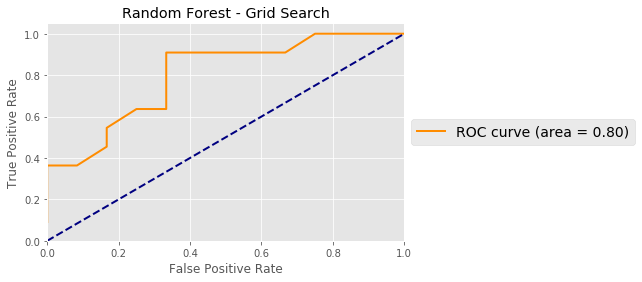

In [25]:
rf_grid_search = gs.best_estimator_
rf_grid_search.fit(X_train, y_train)
y_score = rf_grid_search.predict_proba(X_test)
prediction = rf_grid_search.predict(X_test)

print("Mean Test Accuracy:\t ", round(rf_grid_search.score(X_test, y_test),3))

print("Prediction:\n", [i for i in prediction])
print("True Label:\n", [i for i in y_test])
print("\nConfusion Matrix: \n",confusion_matrix(y_test, prediction))
rf_grid_search_prediction_probabilities = y_score[:,1]
plot_ROC_curve(y_test, rf_grid_search_prediction_probabilities, title="Random Forest - Grid Search")



---
### Build Ensemble with Majority Vote for Traffic Rating Prediction

If each individual model is at least performing better than random we can reduce the prediction error. As seen in the next illustrative plot, the ensemble error is always below the base error if it is below 0.5:

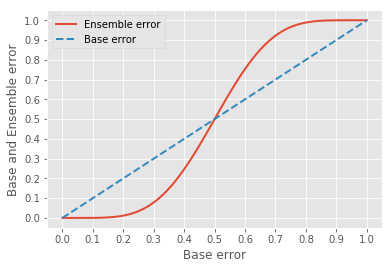

In [26]:
from utils.general_utils import calculate_ensemble_error
from visualization.visualize import plot_ensemble_error 
error_range = np.arange(0.0, 1.01, 0.01)
ensemble_errors = [calculate_ensemble_error(n_classifier=11, error=error) 
               for error in error_range]
plot_ensemble_error(error_range, ensemble_errors)

We used here the implementation of [VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) by scikit learn.

Calculate weights which optimize the accuracy of the classifier and apply them to the models of the ensemble.

In [27]:
from model.ensemble import EnsembleClassifier
from model.train_model import find_best_weights
from sklearn.model_selection import cross_val_score

features_to_use = trackspoints_per_timeinterval
# Train Test Split
y = list(features_to_use["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(features_to_use.drop("rating",axis=1),
                                                    y, test_size=test_size, random_state=random_state)

clf1 =  RandomForestClassifier(random_state=random_state)
clf2 = LogisticRegression(random_state=random_state)
clf3 = SVC(random_state=random_state, probability=True)
np.random.seed(123)

best_weights=find_best_weights([clf1,clf2,clf3],data=[X_train,y_train])
print("\nWinning Weights:")
best_weights.head(1)

Number of 1:  51
Number of 0:  75

Winning Weights:


,w1,w2,w3,mean_score,std_score
0,3.0,1.0,2.0,0.619223,0.108588


**Results of training with majority vote classifier**

In [28]:
from model.ensemble import EnsembleClassifier
from sklearn.ensemble import VotingClassifier

w1=best_weights.loc[0]["w1"]
w2=best_weights.loc[0]["w2"]
w3=best_weights.loc[0]["w3"]
weights = [1,1,1]


rf =  RandomForestClassifier(random_state=random_state)
lr = LogisticRegression(random_state=random_state)
svm = SVC(random_state=random_state, probability=True)
voting_ensemble = VotingClassifier(estimators=[('rf',rf),
                                               ('lr', lr),
                                               ('svm', svm)],
                                               voting='soft',
                                               weights = weights)
voting_ensemble.fit(X_train,y_train)
for clf, label in zip([clf1, clf2, clf3, voting_ensemble], 
                      ['Random Forest','Logistic Regression','Support Vector Machine','Ensemble']):

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Train Accuracy: 0.58 (+/- 0.14) [Random Forest]
Train Accuracy: 0.49 (+/- 0.10) [Logistic Regression]
Train Accuracy: 0.49 (+/- 0.06) [Support Vector Machine]
Train Accuracy: 0.54 (+/- 0.08) [Ensemble]


**Results of testing with majority vote classifier**


Confusion Matrix: 
 Predicted label   0  1
True label            
0                15  4
1                 6  1
Test Accuracy: 0.615384615385
Test AUC: 0.575


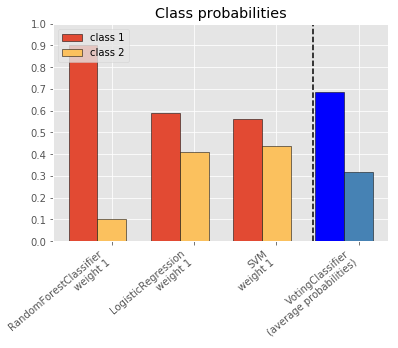

In [29]:
from visualization.visualize import plot_class_probabilities
from sklearn.model_selection import cross_val_score
# predict class probabilities for all classifiers
probas = [c.fit(X_train, y_train).predict_proba(X_test) \
          for c in (clf1, clf2,clf3,voting_ensemble)]

prediction = voting_ensemble.predict(X_test)

print("\nConfusion Matrix: \n",confusion_matrix(y_test, prediction))
print("Test Accuracy:", voting_ensemble.score(X_test,y_test))
print("Test AUC:", np.mean(cross_val_score(voting_ensemble, X_test, y_test, cv=5, scoring='roc_auc')))

plot_class_probabilities(probas, weights)


### Validate the models against a held out validation set

**Simple Logistic Regression Model**


Confusion Matrix: 
 Predicted label  0  1
True label           
0                7  3
1                3  0
Accuracy: 0.538461538462


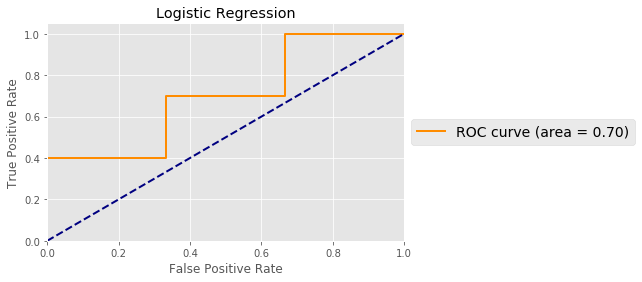

In [30]:
from utils.general_utils import get_binary_labels
X_validation = validation_set.drop(drop_columns,axis=1)
y_validation = get_binary_labels(validation_set["rating"])
X_train = feature_engineered_tracks.drop(drop_columns,axis=1)
y_train = get_binary_labels(feature_engineered_tracks["rating"])

#voting_ensemble.fit(X_train,y_train)
lr = LogisticRegression(random_state=random_state).fit(X_train,y_train)
prediction = lr.predict(X_validation)
y_score = lr.decision_function(X_validation)

print("\nConfusion Matrix: \n",confusion_matrix(y_validation, prediction))
print("Accuracy:", lr.score(X_validation,y_validation))

plot_ROC_curve(y_validation, y_score, title="Logistic Regression", invert=True)



**Binary Class Prediction with Random Forest and 5 fold Cross Validation + Hyperparameter Tuning**


Confusion Matrix: 
 Predicted label  0  1
True label           
0                4  6
1                2  1
Accuracy: 0.538461538462


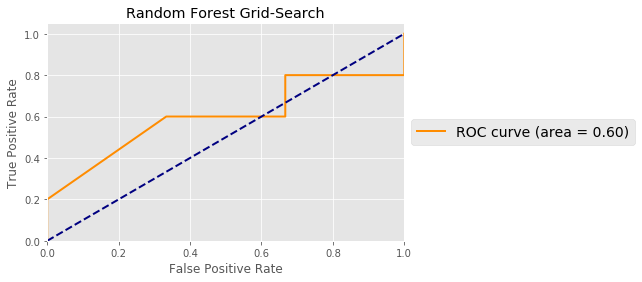

In [31]:
from utils.general_utils import get_binary_labels
X_validation = validation_set.drop(drop_columns,axis=1)
y_validation = get_binary_labels(validation_set["rating"])
X_train = feature_engineered_tracks.drop(drop_columns,axis=1)
y_train = get_binary_labels(feature_engineered_tracks["rating"])

#voting_ensemble.fit(X_train,y_train)
rf_grid_search = gs.best_estimator_
rf_grid_search.fit(X_train, y_train)
prediction = rf_grid_search.predict(X_validation)
y_score = rf_grid_search.predict_proba(X_validation)

print("\nConfusion Matrix: \n",confusion_matrix(y_validation, prediction))
print("Accuracy:", lr.score(X_validation,y_validation))

rf_grid_search_prediction_probabilities = y_score[:,1]
plot_ROC_curve(y_validation, rf_grid_search_prediction_probabilities, title="Random Forest Grid-Search", invert=True)

